<a href="https://colab.research.google.com/github/snchen1230/FM4EO/blob/main/finetune_fm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Easy and Efficient Fine-tuning of Foundation Models for Earth Observation
**Living Planet Symposium, June 22 2025**

Sining Chen and Shan Zhao

Technical University of Munich

## Introduction
This notebook provides two examples for you to get familiar with two toolboxes for easy and efficient fine-tuning of foundation models for Earth observation.

The first toolbox [Dataset4EO](https://github.com/EarthNets/Dataset4EO/tree/streaming) offers a solution for efficient data streaming while fine-tuning or evaluating foundation models. With this, there is no more redundant code blocks for data processing and data loaders needed. All you need to do is to download the binary files containing the data sample batches from our public dataset repositories on hugging face, and directly load GPU batches from them. With the help of the toolbox, the data loading process is expected to be accelerated by more than 5 times!

The second toolbox [TerraTorch](https://github.com/IBM/terratorch) offers a solution for easy fine-tuning of foundation models with well-designed modules. With this, you could choose from a variety of foundation models. And the fine-tuning is implemented with just several lines of codes, instead of redundant blocks of defining models and training processes.

The advantages of the two toolboxes are demonstrated through two use cases: **local climate zone (LCZ) classification**, and **extreme event monitoring**.

<!-- **Please run the following blocks to install and load the dependencies as soon as you open the notebook. It may take ~ 55 min!** -->

In [ ]:
## We have linked the two toolboxes to achieve a better performance. So you are
## going to install a modified version of TerraTorch and Dataset4EO.

# Install modified TerraTorch.
!git clone https://github.com/snchen1230/terratorch.git
%cd terratorch
!pip install -e .
%cd ..

# Install Dataset4EO.
!git clone https://github.com/EarthNets/Dataset4EO.git
%cd Dataset4EO
!pip install -e .
%cd ..

Python 3.11.13


In [ ]:
# !pip install numpy==1.26.4 litdata==0.2.34
# !pip install kornia==0.7.0
# !pip install rasterio torchmetrics
# !pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 --index-url https://download.pytorch.org/whl/cu121
# !pip install ftfy==5.4.1
# !pip install segmentation-models-pytorch
# !pip install torchgeo

  Using cached kornia-0.7.0-py2.py3-none-any.whl.metadata (12 kB)
Using cached kornia-0.7.0-py2.py3-none-any.whl (705 kB)
  Attempting uninstall: kornia
    Found existing installation: kornia 0.8.1
    Uninstalling kornia-0.8.1:
      Successfully uninstalled kornia-0.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchgeo 0.7.0 requires kornia>=0.7.4, but you have kornia 0.7.0 which is incompatible.


In [ ]:
import os
from typing import Dict, List, Optional, Union
import tarfile
import zipfile
import shutil
import time
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import rasterio
import torch
import torch.nn as nn
from torch import Tensor
from torchvision import transforms
from tqdm import tqdm
import segmentation_models_pytorch as smp
from huggingface_hub import hf_hub_download, snapshot_download

import dataset4eo as eodata
import litdata as ld

import terratorch.models import EncoderDecoderFactory
# import models

## 🌳 Use Case I: LCZ Classification

<div style="text-align: center;">
  <img src="https://github.com/snchen1230/FM4EO/blob/main/assets/lcz.png?raw=true" alt="lcz" width="1000"/>
  <div style="margin-top: 8px; font-style: italic;">Figure 1: Left: Schematic drawing of the 17 LCZ classes; middle: the LCZ classification map of Vancouver ,Canada; and right: the Google image of downtown Vancouver, bounded by the yellow rectangle in the classification map.</div>
</div>

Local climate zones show great potential in urban morphology mapping. There are a total of 17 classes in the LCZ classification scheme, where 10 are built classes and 7 are natural classes. They are based on climate-releavnt surface properties on local scale, which are mainly related to 3D surface structure (e.g., height and density of buildings and trees), surface cover (e.g., vegetation or paving), as well as anthropogenic parameters (such as human-based heat output).

In this section, we try to fine-tune **DOFA** on the **So2Sat-LCZ42** dataset.

### 📊 Data

We are using the **[So2Sat-LCZ42](https://https://arxiv.org/abs/1912.12171)** dataset in this demo, which is a benchmark datsaet for global local climate zones classification. The dataset covers 42 urban agglomerations around the globe. It contains 400,673 pairs of Sentinel-1 SAR and Sentinel-2 multi-spectral image patches with the corresponding manually labeled LCZ labels. The LCZ classification task is regarded as a image classification task.

A data sample is visualized in the following block.


In [1]:
## Visualize a sample of So2Sat.
from torchgeo.datasets import So2Sat

dataset_train = So2Sat(root="data/so2sat_raw", split="test")

sample = dataset_train[0]
dataset_train.plot(sample)

ModuleNotFoundError: No module named 'torchgeo'

Usually, this is how you prepare data tailored for deep neural network training.

1.   🔍 Search for the dataset on the Internet
2.   📂 Download and extract the data
3.   📄 Write lengthy codes for the `Dataset` instance.

In some cases when you are lucky enough, you will find many popular datasets built in the library **[TorchGeo](https://github.com/microsoft/torchgeo)**, which could simplify the process a lot.

This annoying process is illustrated in the following blocks.

In [ ]:
## Prepare data with the help of TorchGeo.
start = time.time()

# Load a data class from TorchGeo.
dataset_train_full_bands = So2Sat(root="data/so2sat_raw", split="train")

# Get a dataloader on the dataset.
train_loader_full_bands = torch.utils.data.DataLoader(
                dataset=dataset_train_full_bands,
                batch_size=2,
                shuffle=True,
                drop_last=True,
            )

stop = time.time()
prepare_time1 = stop - start

print(f"The data preparation process takes {prepare_time1:03f} s.")

In [ ]:
## Try to iterate over the dataloaders
iters = 0
start = time.time()
for sample in train_loader_full_bands:
  img, cls = sample["image"], sample["label"]
  iters += 1
  if iters == 100:
    break
stop = time.time()
loading_time1 = stop - start

print(f"The data loading speed is {loading_time1:03f} s per 100 batches.")

Instead of doing these, we can actually simply do the follwing with the help of **`Dataset4EO`**.

1.   🤗 Download the process-ready binary files from the public huggingface repositories.
2.   ✅ Load the dataset with one code line.



In [ ]:
## Prepare data with the help of Dataset4EO.
start = time.time()

# Get the repository ID on huggingface of the built-in datasets.
repo_id = eodata.builtin_datasets['so2sat']

# Download the process-ready binary files from the public hugginface repositories.
local_path = snapshot_download(
    repo_id=repo_id,
    repo_type="dataset",
    cache_dir="data/so2sat_bin",
    revision="main"
)

# Build a streaming dataset.
dataset_train_full_bands = eodata.StreamingDataset(
    input_dir = f"{local_path}/train",
    num_channels=18,
    channels_to_select=list(range(18)),
    shuffle=True,
    drop_last=True
)

# Build a dataloader
train_loader_full_bands = ld.StreamingDataLoader(dataset_train_full_bands, batch_size=2)

stop = time.time()
prepare_time2 = stop - start

print(f"With the help of Dataset4EO, the data preparation process takes {prepare_time2:03f} s, {((prepare_time1-prepare_time2)/prepare_time1*100):2f} % faster than torchgeo!")

In [ ]:
## Try to iterate over the dataloaders
iters = 0
start = time.time()
for sample in train_loader_full_bands:
  img, cls = sample["image"], sample["class"]
  iters += 1
  if iters == 100:
    break

end= time.time()
loading_time2 = end - start

print(f"The data loading speed is {loading_time2:03f} s per 100 batches, {((loading_time1-loading_time2)/loading_time1*100):2f} % faster than before!")

By doing this, the data loading process is accelerated.

For the case, we only need a subset of channels for fine-tuning. Guess what, `Dataset4EO` also supports selection of bands of multi-channel input images!

In [ ]:
## Load only the bands needed.

# Function to get the band names from the metadata.
def get_selected_bands(bands_list):
  with open(f"{local_path}/train/metadata.json") as f:
    data = json.load(f)
    return data["attributes"]["bands"][bands_list]

# define the indices of bands needed.
bands_list = [0, 2, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
bands_name = get_selected_bands(bands_list)

print("Following bands are selected:")
for band_name in bands_name:
  print(band_name)
print("------------------------------")

# Build a streaming dataset.
dataset_train = eodata.StreamingDataset(
    input_dir = f"{local_path}/train",
    num_channels=18,

    # replace this with bands needed.
    channels_to_select=bands_list,

    shuffle=True,
    drop_last=True
  )

train_loader = ld.StreamingDataLoader(dataset_train, batch_size=2)

sample = next(train_loader_full_bands)
img1 = sample["image"]

sample = next(train_loader)
img2 = sample["image"]
print("The complete data contains images of size {img1.shape}, while the dataset with selected bands contains images of size {img2.shape}.")

### 🧠 Model

We use [**DOFA**](https://arxiv.org/abs/2403.15356) in this use case. DOFA is a unified multimodal foundation model for different data modalities in remote sensing and Earth observation. It is pretrained using five different data modalities in remote sensing and Earth observation. It can handle images with any number of input channels. Inspired by neuroplasticity, DOFA emulate the brain mecahnism for adjusting to new experiences or environmental shifts for processing multimodal EO data.

<div style="text-align: center;">
  <img src="https://github.com/zhu-xlab/DOFA/blob/master/assets/DOFA-model.png?raw=true" alt="ExEBench" width="600"/>
  <div style="margin-top: 8px; font-style: italic;">Figure 2: Overview of DOFA.</div>
</div>

LCZ Classification is an image classification task, so linear probing will be enough for this purpose. The encoder is frozen to utilize the features extracted by DOFA, and a linear layer is applied to the features and optimized with the dataset. With the help of TerraTorch, the model can be defined easily by the following lines of codes.


In [ ]:
# Fetch a model factory from the library, encoder-decoder fits the use case.
model_factory = EncoderDecoderFactory()

# Define the model by "build_model" method.
model = model_factory.build_model(

    # Task to be performed. This argument defines the head module. In our case,
    # the task is "classification", you can also choose from "regression" and
    # "segmentation" for other purposes.
    task = "classification",

    # Backbone to be used. This defines the foundation model you like as the
    # encoder. For DOFA, there are also "dofa_small_patch16_224", and
    # "dofa_large_patch16_224".
    backbone = "dofa_base_patch16_224",

    # Decoder to be used. For linear probing, no decoder is needed, we just need
    # to pass the feature straight to the head. For other purposes, you can also
    #choose from "FCNDecoder", "UperNetDecoder", "ASPPSegmentationHead",
    # "ASPPRegressionHead", "MLPDecoder", "UNetDecoder", and "LinearDecoder".
    decoder = "IdentityDecoder",

    # (Optional) Define backbone arguments. You could define them in a dict and
    # pass them to the argument ("backbone_kwargs") or as multiple arguments
    # starting with "backbone_".
    # "backbone_pretrained" is set as True to use the pretrained weights of
    # DOFA, else the model will be randomly initialized.
    backbone_pretrained = True,
    # DOFA utilizes the band information in the model architecture, so the band
    # information of the dataset images should be explicitly listed here.
    backbone_model_bands = bands_name,

    # (Optional) Similarly, you could also define decoder arguments
    # ("decoder_kwargs") and head arguments ("head_kwargs").

    # Number of classes is set to correspond with the categories of So2Sat
    # dataset. This defines the output channels of the classification head.
    num_classes = 17,

    # Necks connect the backbones and heads, i.e., perform some refienments or
    # reconfigurations on the raw feature maps produced by the backbone. Since
    # the features from DOFA is sized [batch, number of patches, embedding dim],
    # "ReshapeTokensToImage" project them back to the
    # [batch, channel, height, width] shapes. In TerraTorch, necks are defined
    # as a list of dicts, which will be used to fetch nn.Modules.
    necks = [{"name": "ReshapeTokensToImage"}]
)

### 🚆 Training
Let's get started to fine-tune the model!

In [ ]:
torch.cuda.empty_cache() # Clear caches.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

num_epochs = 20

# Cross entropy as the loss function.
criterion = nn.CrossEntropyLoss()

# AdanW as the optimizer.
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-3,
    weight_decay=5e-6,
)

# Cosine annealing for learning rate scheduling.
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=0, last_epoch=-1, verbose=False)


In [ ]:
# Start training!
for epoch in range(num_epochs):
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for train_data in pbar:
        model.train()
        x_train = train_data["image"].float()  # (b, 1, w, h)
        y_train = train_data["class"]
        output = model(x_train)
        logit = output.output
        loss = criterion(logit, y_train)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        epoch_loss += loss.item()
        avg_loss = epoch_loss / (pbar.n + 1)
        pbar.set_postfix(loss=avg_loss)

    lr_scheduler.step()
    epoch_loss /= len(train_loader)

In [ ]:
# Save the checkpoint
ckp_folder = "./lcz_cls"
os.makedirs(ckp_folder, exist_ok=True)
ckp_path = os.path.join(ckp_folder, "last_model.pth")
print(f"Training finished! save the model to {ckp_path}")
torch.save(model.state_dict(), ckp_path)

### ✅ Evaluation
Let's evaluate the fine-tuned model!

In [ ]:
## Build the test dataloader.
dataset_test = eodata.StreamingDataset(
    input_dir = f"{local_path}/test",
    num_channels=18,
    channels_to_select=bands_list,
    shuffle=False,
  )

test_loader = ld.StreamingDataLoader(dataset_test, batch_size=1)

## Load the trained model.
model.load_state_dict(torch.load(ckp_path, weights_only=True))
model.eval()

In [ ]:
## Evaluate
from torchmetrics import Accuracy

# Initialize metrics
test_macro_acc = Accuracy(task="multiclass", num_classes=17, average="macro")
criterion = nn.CrossEntropyLoss()
total_pred, total_gt = [], []
total_loss = 0

model.eval()
with torch.no_grad():
    for batch_id, batch_data in enumerate(test_loader):
        x = batch_data["image"].to(device)
        y = batch_data["class"].to(device)  # shape: (batch, 1, H, W)

        # Forward pass with optional coordinates
        output = model(x)
        logit = output.output
        # Calculate loss
        loss = criterion(logit, y)
        total_loss += loss.item()

        # Prediction: softmax + argmax over classes
        probs = torch.nn.functional.softmax(logits, dim=1)  # (batch, classes, H, W)
        preds = torch.argmax(probs, dim=1).int()  # (batch, H, W)

        # Store flattened predictions and ground truths for global metrics
        total_pred.append(preds.flatten())
        total_gt.append(y.squeeze(1).flatten().int())

    # Concatenate all predictions and ground truths
    final_pred = torch.cat(total_pred)
    final_gt = torch.cat(total_gt)

    # Compute overall metrics
    macro_acc = test_macro_acc(final_pred, final_gt).item() * 100

    print(
        f"\nOverall Performance:\n"
        f" - Macro Accuracy: {macro_acc:.2f}%\n"
        f" - Average Loss: {total_loss / len(test_loader):.2f}"
    )

In [ ]:
## Visualize the results.
n_row = 5
n_col = 3

figure, axes = plt.subplots((5, 3))

vis_bands = [10, 9, 8]
with torch.no_grad():
    for batch_id, batch_data in enumerate(test_loader):
        x = batch_data["image"].to(device)
        y = batch_data["class"].to(device)

        output = model(x)
        logit = output.output
        probs = torch.nn.functional.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).int()

        axes[batch_id // num_col, batch_id % num_col].imshow(x.cpu().numpy()[0][vis_bands])
        axes[batch_id // num_col, batch_id % num_col].set_title(f"GT: {y.item()}, Pred: {preds.item()}")
plt.imshow()

## 🔥 Use Case II: Extreme Event Monitoring

<div style="text-align: center;">
  <img src="https://github.com/snchen1230/FM4EO/blob/main/assets/ExE.png?raw=true" alt="ExEBench" width="600"/>
  <div style="margin-top: 8px; font-style: italic;">Figure 3: Overview of ExEBench.</div>
</div>

Our planet is facing increasingly frequent extreme events, which pose major risks to human lives and ecosystems. In this tutorial, we will explore the potential of Foundation Models (FMs) in disaster management. Specifically, we utilized ExEBench (Extreme Earth Benchmark), a collection of seven extreme event categories across floods, wildfires, storms, tropical cyclones, extreme precipitation, heatwaves, and cold waves, to assess the model performance, efficiency, and generalizability in extreme events detection, monitoring, and forecasting.

Read the full benchmark paper: https://arxiv.org/pdf/2505.08529.

In this section, we focus on the **Wildfire** 🔥 case study. We will try to fine-tune **[Prithvi-EO-2.0](https://arxiv.org/abs/2412.02732)** on the **ExEBench Fire** dataset.

### 📊 Data
The ExEBench Fire dataset contains Harmonized Landsat and Sentinel-2 (HLS) satellite imagery, with corresponding burned scar masks. Each sample in the dataset includes: (1) A HLS image, (2) the associated burned scars map, and (3) the geolocation metadata for the image

This setup supports supervised learning tasks such as burned area mapping / segmentation

In this case, the ExEBench is a newly released dataset, and is not supported by TorchGeo yet. So you have to go through the annoyging process by yourself.

1.   🔍 Search for the dataset on the Internet
2.   📂 Download and extract the data
3.   📄 Write lengthy codes for the Dataset instance.

Just as the code blocks below.

In [ ]:
## Download and extract the data

extract_dir = "./data/exebench_raw"
os.makedirs(extract_dir, exist_ok=True)
# Download the zip file from huggingface
tar_path = hf_hub_download(repo_type="dataset", repo_id="anonyau/ee-bench", filename="fire.tar")

# Extract the .tar file
with tarfile.open(tar_path) as tar:
    tar.extractall(extract_dir)

# Remove the .tar file
os.remove(tar_path)

# Step 3: Find and extract the .zip file that was inside the .tar
zip_path = os.path.join(extract_dir, "fire.zip")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Remove the .zip file
os.remove(zip_path)

print("Extracted contents to:", extract_dir)


Extracted contents to: ./data/exebench_raw


In [ ]:
# Define the transform
class ResizeTransform:
    def __init__(self, size):
        self.size = size

    def __call__(self, image, label):
        image = torch.nn.functional.interpolate(image.unsqueeze(0), size=self.size, mode='bilinear', align_corners=False).squeeze(0)
        label = torch.nn.functional.interpolate(label.unsqueeze(0).float(), size=self.size, mode='nearest').long().squeeze(0)
        return image, label

# Customized the dataset
class MultispectralDataset(torch.utils.data.Dataset):
    """
    Multispectral image dataset for burn scar classification (HLS).
    Bands:
        1. Blue  (B02)
        2. Green (B03)
        3. Red   (B04)
        4. NIR   (B8A)
        5. SWIR1 (B11)
        6. SWIR2 (B12)
    Data source: https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars
    """
    def __init__(
        self,
        split: str = "train",
        bands: Optional[List[int]] = [0,1,2,3,4,5],
        disaster: str = "fire",
        transform: Optional = None,
    ):
        """
        Args:
            split (str): One of 'train' or 'test'.
            bands (List[int], optional): 0-based band indices to extract, or None to load all 6 bands.
            disaster (str): Disaster type, e.g., 'fire'.
            transform (callable, optional): A transform function applied to both image and label.
        """
        assert split in {"train", "test"}, "split must be 'train' or 'test'"
        self.split = split
        self.data_path = os.path.join('data/exebench_raw', disaster,  f"{split}ing")
        self.bands = bands
        self.transform = transform
        self.means = np.array([0.0333, 0.0570, 0.0589, 0.2323, 0.1973, 0.1194])[bands]
        self.stds = np.array([0.0227, 0.0268, 0.0400, 0.0779, 0.0871, 0.0724])[bands]
        self.filenames = self._read_split()

    def _read_split(self) -> List[str]:
        split_filename = f"{self.split}ing_index.csv"
        split_filepath = self.data_path / split_filename
        split_data = pd.read_csv(split_filepath)
        filenames = split_data.iloc[:, 0]
        filenames = [x[:-11] for i, x in enumerate(filenames)]
        return filenames

    def __len__(self) -> int:
        return len(self.filenames)

    def normalize(self, image: np.ndarray) -> np.ndarray:
        """Normalize image using precomputed means and stds for each band."""
        return (image -self.means[:, None, None]) / self.stds[:, None, None]

    def unnormalize(self, image: np.ndarray) -> np.ndarray:
        """Normalize image using precomputed means and stds for each band."""
        return (image * self.stds[:, None, None] + self.means[:, None, None])

    def __getitem__(self, idx: int) -> Dict[str, Union[Tensor, None]]:
        filename = self.filenames[idx]
        image_path = self.data_path / f"{filename}_merged.tif"
        label_path = self.data_path / f"{filename}.mask.tif"

        with rasterio.open(image_path) as dataset:
            # Default to read all six bands
            image = dataset.read()  # shape: [6, H, W]
            # Optional, you could choose the bands to read
            image = np.stack([image[b] for b in self.bands], axis=0)  # CHW
            image = self.normalize(image)
            # Prithvi-2 takes the longitude and latitude as inputs
            try:
                spatial_coords = dataset.lnglat()
                spatial_coords = torch.tensor(spatial_coords, dtype=torch.float32)
            except Exception:
                spatial_coords = None

        # Load and preprocess label
        label = np.array(Image.open(label_path))  # shape: [H, W]
        label[label == -1] = 0  # Convert missing data to non-fire
        label = np.expand_dims(label, axis=0)  # shape: [1, H, W]

        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image, label = self.transform(image, label)

        return {
            "image": image,               # Normalized HLS image Tensor [C, H, W]
            "class": label,              # Label Tensor [1, H, W]
            "spatial_coords": spatial_coords,  # Optional[Tensor[2]]
        }

#### 🖼️ Sample visualization
Plot one sample from the Fire dataset

Scenes contain six bands, and masks have one band (1 = Burn scar, 0 = Not burned, -1 = Missing data)

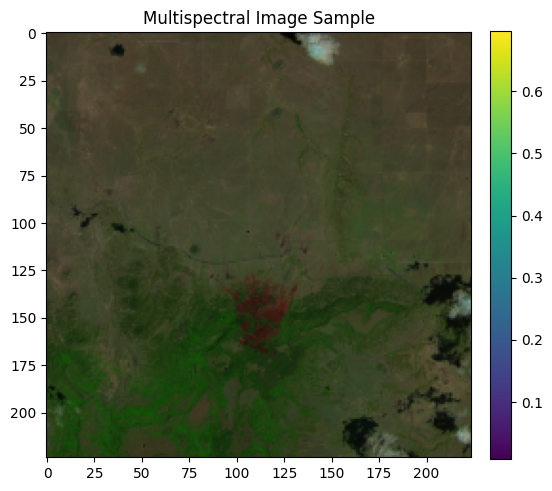

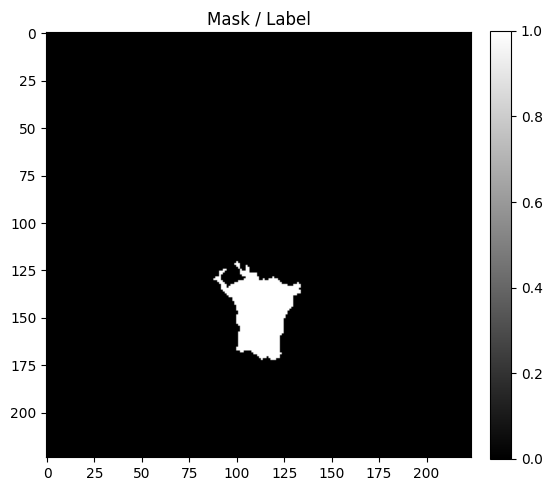

tensor([-103.9365,   37.0223])

In [ ]:
# Define the transformation. To reduce computational cost, we resize images and labels from 512x512 to 224x224
resize_transform = ResizeTransform(224)

# Create dataset instance
vis_dataset = MultispectralDataset(
    split="train",
    bands=[5, 3, 2],       # Using bands 6, 4, 3 (SWIR2, Red, Green) for better visualization of burned scars, vegetation, etc.
    disaster="fire",
    transform=resize_transform,
)

# Get one sample
index = 2
sample = vis_dataset[index]
img = vis_dataset.unnormalize(sample["x"])
label = sample["y"]

# Plot the image
plt.figure(figsize=(6, 6))
plt.imshow(img.permute(1, 2, 0))
plt.title("Multispectral Image Sample")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

# Plot the label/mask
plt.figure(figsize=(6, 6))
plt.imshow(label[0], cmap="gray")
plt.title("Mask / Label")

plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

# Geolocation of the image
spatial_coords = sample["spatial_coords"]
spatial_coords

#### Data Streaming
🤗 Download processed binary batch files from huggingface

In [ ]:
snapshot_download(
    repo_id = "snchen1230/ExEBench.Fire",
    repo_type = "dataset",
    local_dir = "data/exebenchfire_bin",
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

chunk-4-0.bin:   0%|          | 0.00/89.9M [00:00<?, ?B/s]

chunk-0-0.bin:   0%|          | 0.00/89.6M [00:00<?, ?B/s]

chunk-2-0.bin:   0%|          | 0.00/89.7M [00:00<?, ?B/s]

chunk-3-0.bin:   0%|          | 0.00/88.1M [00:00<?, ?B/s]

chunk-5-0.bin:   0%|          | 0.00/89.3M [00:00<?, ?B/s]

chunk-1-0.bin:   0%|          | 0.00/91.9M [00:00<?, ?B/s]

chunk-6-0.bin:   0%|          | 0.00/87.0M [00:00<?, ?B/s]

chunk-7-0.bin:   0%|          | 0.00/88.8M [00:00<?, ?B/s]

index.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

metadata.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

chunk-0-0.bin:   0%|          | 0.00/184M [00:00<?, ?B/s]

chunk-2-0.bin:   0%|          | 0.00/182M [00:00<?, ?B/s]

chunk-1-0.bin:   0%|          | 0.00/184M [00:00<?, ?B/s]

chunk-3-0.bin:   0%|          | 0.00/182M [00:00<?, ?B/s]

chunk-4-0.bin:   0%|          | 0.00/184M [00:00<?, ?B/s]

chunk-5-0.bin:   0%|          | 0.00/184M [00:00<?, ?B/s]

chunk-7-0.bin:   0%|          | 0.00/180M [00:00<?, ?B/s]

chunk-6-0.bin:   0%|          | 0.00/180M [00:00<?, ?B/s]

index.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

metadata.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

'/content/data/exebenchfire_bin'

### 🧠 Model

FMs are large-scale pre-trained models designed to understand and generate complex data across multiple domains. They learn from vast datasets and can be adapted to various downstream tasks with minimal fine-tuning.

Prithvi-EO-2.0 is a specialized Foundation Model developed for Earth observation tasks. It leverages multi-modal data to improve accuracy in identifying environmental phenomena such as wildfires, floods, and storms. In this tutorial, we use Prithvi-EO-2.0 to analyze the Fire dataset and demonstrate how foundation models can enhance disaster mapping workflows.

Bellow is the code of loading Prithvi-EO-2.0 based on the [TerraTorch](https://ibm.github.io/terratorch/stable/) library.



In [ ]:
import terratorch
from terratorch.models import EncoderDecoderFactory
from terratorch.datasets import HLSBands

model_factory = EncoderDecoderFactory()

# Let's build a segmentation model
# Parameters prefixed with backbone_ get passed to the backbone
# Parameters prefixed with decoder_ get passed to the decoder
# Parameters prefixed with head_ get passed to the head

model = model_factory.build_model(
    task="segmentation",
    backbone="prithvi_eo_v2_300",
    backbone_pretrained=True,
    backbone_bands=[
        HLSBands.BLUE,
        HLSBands.GREEN,
        HLSBands.RED,
        HLSBands.NIR_NARROW,
        HLSBands.SWIR_1,
        HLSBands.SWIR_2,
    ],
    necks=[{"name": "SelectIndices", "indices": [5,11,17,23]},
           {"name": "ReshapeTokensToImage"}],
    decoder="UperNetDecoder",
    decoder_channels=128,
    head_dropout=0.1,
    num_classes=2,
)


## 🛠️ Prepare the Model
We implement fine-tuning by freezing the encoder and updating only the decoder weights. This allows the model to retain its general-purpose representation capabilities while adapting the decoder to the Fire dataset for downstream tasks.

In [ ]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 MiB. GPU 0 has a total capacty of 14.74 GiB of which 4.12 MiB is free. Process 41044 has 14.73 GiB memory in use. Of the allocated memory 13.30 GiB is allocated by PyTorch, and 1.28 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## 🛠️ Prepare the training data

In [ ]:
import time

In [ ]:
# For the training, use the full six bands
dataset_train = MultispectralDataset(
    split="train",
    disaster="fire",
    transform=ResizeTransform(224),
)

batch_size = 1
train_loader = torch.utils.data.DataLoader(
                dataset=dataset_train,
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
            )

iters = 0
start = time.time()
for sample in train_loader:
  img, cls, spatial_coords = sample["image"], sample["class"], sample["spatial_coords"]
  iters += 1
  if iters == 100:
    break
end = time.time()
print("Customized dataloader: ", f"{end-start:.2f}", "s per 100 batch")

Customized dataloader:  5.27 s per 100 batch


In [ ]:
dataset_train = eodata.StreamingDataset('data/exebenchfire_bin/train', num_channels=6, channels_to_select=[0, 1, 2, 3, 4, 5], shuffle=True, drop_last=True)
train_loader = ld.StreamingDataLoader(dataset_train, batch_size=2)

iters = 0
start = time.time()
for sample in train_loader:
  img, cls, spatial_coords = sample["image"], sample["class"], sample["spatial_coords"]
  iters += 1
  if iters == 100:
    break
end = time.time()
print("Data streaming: ", f"{end-start:.2f}", "s per 100 batch")

Data streaming:  6.16 s per 100 batch


# Section 3 Finetunning

## 🏋️ Training loops

In [ ]:
transform=ResizeTransform(64)
num_epochs = 20
# Burn scars account for only 11% of the total pixels in the dataset. So we use the DICE loss for segmentation tasks with imbalanced class distributions.
criterion = smp.losses.DiceLoss(mode="multiclass", from_logits=True)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-3,
    weight_decay=5e-6,
)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=0, last_epoch=-1, verbose=False)


for epoch in range(num_epochs):
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for train_data in pbar:
        # print(train_data["image"].shape, train_data["class"].shape)
        model.train()
        # x_train = train_data["image"].float().to(device)
        x_train = train_data["image"].float()  # (b, 1, w, h)
        x_train = torch.nn.functional.interpolate(x_train, size=64, mode='bilinear', align_corners=False).to(device)
        coord_train = train_data.get("spatial_coords").float().to(device)
        y_train = train_data["class"]
        y_train = torch.nn.functional.interpolate(y_train, size=64, mode='nearest').long().to(device)
        output = model(x=x_train, temporal_coords=None, location_coords=coord_train)
        logit = output.output
        loss = criterion(logit, y_train)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        epoch_loss += loss.item()
        avg_loss = epoch_loss / (pbar.n + 1)
        pbar.set_postfix(loss=avg_loss)

    lr_scheduler.step()
    epoch_loss /= len(train_loader)


Epoch 1/20:   0%|          | 0/270 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 14.74 GiB of which 2.12 MiB is free. Process 41044 has 14.74 GiB memory in use. Of the allocated memory 13.30 GiB is allocated by PyTorch, and 1.28 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## 💾 Save the checkpoint

In [ ]:
ckp_folder = "./exebenchfire"
os.makedirs(ckp_folder, exist_ok=True)
ckp_path = os.path.join(ckp_folder, "last_model.pth")
print(f"training finished! save the model to {ckp_path}")
torch.save(model.state_dict(), ckp_path)

# Section 4 Evaluation

## 🚀 Load the finetuned checkpoint

In [ ]:
model.load_state_dict(torch.load(ckp_path, weights_only=True))
model.eval()

## 🛰️ Test dataset

In [ ]:
dataset_test = MultispectralDataset(
    split="test",
    disaster="fire",
)
test_loader = torch.utils.data.DataLoader(
                dataset=dataset_test,
                batch_size=1,
                shuffle=False,
                drop_last=False,
            )

## 📝 Report the results

We evaluate the segmentation performance using three common metrics:

### Intersection over Union (IoU)  
Measures the overlap between the predicted segmentation and the ground truth:

$$
\text{IoU} = \frac{|\text{Prediction} \cap \text{Ground Truth}|}{|\text{Prediction} \cup \text{Ground Truth}|}
$$


### F1-Score
Harmonic mean of precision and recall, commonly used for imbalanced segmentation tasks:

$$
\text{F1} = \frac{2 \times |\text{Prediction} \cap \text{Ground Truth}|}{|\text{Prediction}| + |\text{Ground Truth}|}
$$

### Accuracy  
Proportion of correctly classified pixels:

$$
\text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Pixels}}
$$

These metrics collectively assess how well the model identifies burned areas compared to the true burned scar maps.




In [ ]:
from torchmetrics import JaccardIndex, F1Score, Accuracy

# Initialize metrics
test_f1 = F1Score(num_classes=2, task="binary")
test_iou = JaccardIndex(task="multiclass", num_classes=2)
test_miou_macro = JaccardIndex(task="multiclass", num_classes=2, average="macro")
test_macro_acc = Accuracy(task="multiclass", num_classes=2, average="macro")

# Loss function
criterion = smp.losses.DiceLoss(mode="multiclass")

total_pred, total_gt = [], []
total_loss = 0

model.eval()
with torch.no_grad():
    for batch_id, batch_data in enumerate(test_loader):
        x = batch_data["image"].to(device)
        y = batch_data["class"].to(device)  # shape: (batch, 1, H, W)
        coords = batch_data.get("spatial_coords")

        # Forward pass with optional coordinates
        output = model(x, None, coords)
        logit = output.output
        # Calculate loss
        loss = criterion(logit, y)
        total_loss += loss.item()

        # Prediction: softmax + argmax over classes
        probs = torch.nn.functional.softmax(logits, dim=1)  # (batch, classes, H, W)
        preds = torch.argmax(probs, dim=1).int()  # (batch, H, W)

        # Store flattened predictions and ground truths for global metrics
        total_pred.append(preds.flatten())
        total_gt.append(y.squeeze(1).flatten().int())

        # Compute metrics per batch (on CPU)
        f1_score = test_f1(preds.cpu(), y.squeeze(1).cpu()).item() * 100
        iou_score = test_iou(preds.cpu(), y.squeeze(1).cpu()).item() * 100

        print(f"Batch {batch_id}: F1 Score = {f1_score:.2f}%, IoU = {iou_score:.2f}%")

    # Concatenate all predictions and ground truths
    final_pred = torch.cat(total_pred)
    final_gt = torch.cat(total_gt)

    # Compute overall metrics
    f1_unweighted = test_f1(final_pred, final_gt).item() * 100
    iou_unweighted = test_iou(final_pred, final_gt).item() * 100
    miou_macro = test_miou_macro(final_pred, final_gt).item() * 100
    macro_acc = test_macro_acc(final_pred, final_gt).item() * 100

    print(
        f"\nOverall Performance:\n"
        f" - F1 Score (Unweighted): {f1_unweighted:.2f}%\n"
        f" - IoU (Unweighted): {iou_unweighted:.2f}%\n"
        f" - Mean IoU (Macro): {miou_macro:.2f}%\n"
        f" - Macro Accuracy: {macro_acc:.2f}%\n"
        f" - Average Loss: {total_loss / len(test_loader):.2f}"
    )

## 🖼️ Results Visualization

In [ ]:
mean = np.array([0.0333, 0.0570, 0.0589, 0.2323, 0.1973, 0.1194])[[5, 3, 2]]
std = np.array([0.0227, 0.0268, 0.0400, 0.0779, 0.0871, 0.0724])[[5, 3, 2]]

target_test_numpy = y_test.detach().cpu().numpy()[0, 0]
x_test_numpy = x_test.detach().cpu().numpy()[:, [5, 3, 2], :, :][0]
output_test_numpy = pred_test.detach().cpu().numpy()[0]

fig, axes = plt.subplots(3, 1, figsize=(5, 15))
cmap = plt.cm.get_cmap('viridis', 2)  # Discrete colormap with 3 categories
labels = ['No \nburned', 'Burned']

normBackedData = x_test_numpy * std[:, None, None] + mean[:, None, None]
im0= axes[0].imshow(normBackedData.transpose((1, 2, 0)))
cbar0 = fig.colorbar(im0, ax=axes[0], orientation='vertical', pad=0.05)
cbar0.set_label('Reflectance', fontsize=14)
axes[0].set_title("Input", fontsize=14)
axes[0].axis('off')


im1 = axes[1].imshow(target_test_numpy, vmin=0, vmax=1.0, cmap=cmap)
cbar1 = fig.colorbar(im1, ax=axes[1], orientation='vertical', pad=0.05)
cbar1.set_ticks([0, 1])  # Explicitly set the tick locations
cbar1.set_ticklabels(labels, fontsize=14)  # Set the tick labels
# cbar1.set_label('Categories', fontsize=14)
axes[1].set_title("Label", fontsize=14)
axes[1].axis('off')

im2 = axes[2].imshow(output_test_numpy, vmin=0, vmax=1.0, cmap=cmap)
cbar2 = fig.colorbar(im2, ax=axes[2], orientation='vertical', pad=0.05)
cbar2.set_ticks([0, 1])  # Explicitly set the tick locations
cbar2.set_ticklabels(labels, fontsize=14)  # Set the tick labels
axes[2].set_title("Prediction", fontsize=14)
axes[2].axis('off')
